In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
# to make plots match dark theme in jupyter lab
plt.style.use('dark_background')

In [2]:
df1 = pd.read_csv('data/Metro_Zhvi_SingleFamilyResidence.csv')

In [3]:
df1.head()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02
0,102001,United States,0,106409.0,106560.0,106737.0,106910.0,107128.0,107351.0,107614.0,...,238053,238779,239549,240338,241143,241961,242760,243578,244440,245386
1,394913,"New York, NY",1,189376.0,189043.0,188739.0,188553.0,188461.0,188504.0,188629.0,...,475533,475912,476471,477020,477381,477515,477746,478297,479081,479971
2,753899,"Los Angeles-Long Beach-Anaheim, CA",2,192140.0,192143.0,192208.0,192359.0,192348.0,192275.0,192216.0,...,685436,686283,687894,690303,693953,697273,700235,704585,710138,718974
3,394463,"Chicago, IL",3,162321.0,161707.0,161373.0,160886.0,161449.0,162263.0,163930.0,...,243265,243491,243848,244063,244154,244153,244137,244226,244415,244624
4,394514,"Dallas-Fort Worth, TX",4,113140.0,113481.0,113727.0,113913.0,114131.0,114357.0,114688.0,...,252542,253044,253660,254304,255076,255509,255856,255972,256267,256718


In [4]:
df1.shape

(914, 290)

In [5]:
# Lets remove United States and focus on city and state
state_df = df1.iloc[1:, :].copy()

In [6]:
# Drop unneeded columns
state_df.drop(['RegionID', 'SizeRank'], inplace=True, axis=1)

In [7]:
# make YY-MM columns start on the first to make our lives easier
state_df.rename(dict(zip(state_df.columns[1:], [f'{c}-01' for c in state_df.columns[1:]])), 
                inplace=True, axis='columns')

In [8]:
# Split RegionName into city and state
state_df['City'] =  [x.split(', ')[0] for x in state_df['RegionName']]
state_df['State'] = [y.split(', ')[1] for y in state_df['RegionName']]
state_df.drop(['RegionName'], inplace=True, axis=1)

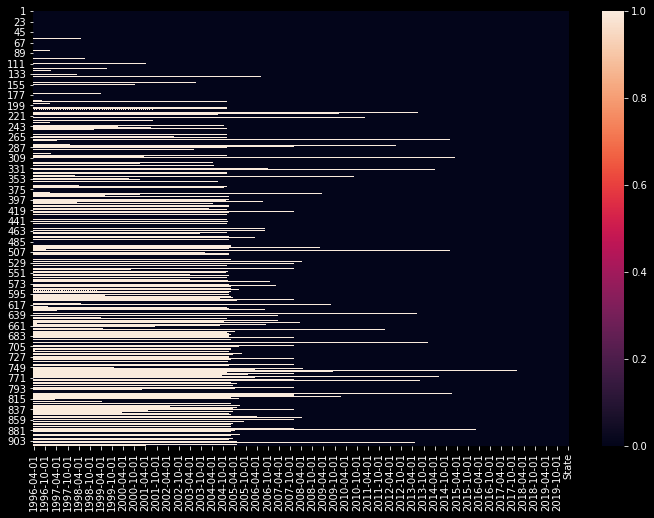

In [9]:
# Lets see the null values
plt.figure(figsize=(12, 8))
sns.heatmap(state_df.isna());

In [10]:
state_df.set_index('City', inplace=True)

In [11]:
# Make time series by state code
def state_df_maker(state_code):
    if type(state_code) != str:
        type(state_code) == str
    state_data = state_df[state_df['State'] == state_code.upper()].copy()
    state_data.reset_index(inplace=True)
    state_data = state_data.transpose()
    state_data.columns = state_data.iloc[0]
    state_data.drop(state_data.index[0], inplace=True)
    # convert to numeric, ignore the NaNs
    state_data.apply(pd.to_numeric, errors='ignore')
    state_data.index = pd.to_datetime(state_data.index, format="%Y-%m-%d", errors='coerce')
    # We dont need the state code
    return state_data[:-1]

In [12]:
ohio_df = state_df_maker('OH')

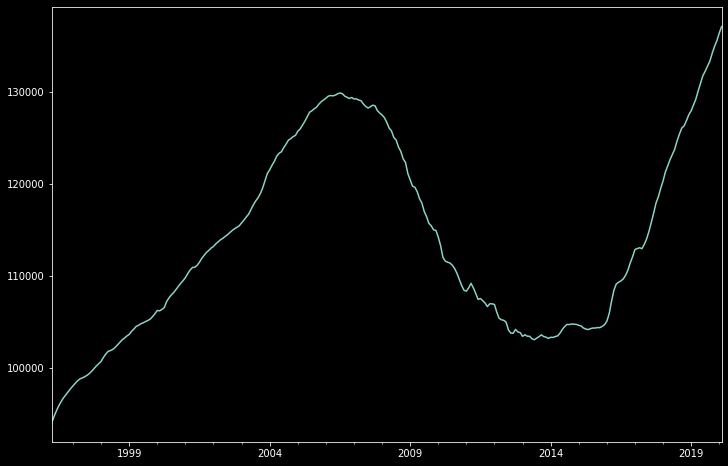

In [13]:
plt.figure(figsize=(12, 8))
ohio_df['Dayton'].plot();

## What economic factors could effect the housing market

In [14]:
# TODO: Keep the date column to make index

def make_econ_data(dir_path):
    econ_data = pd.DataFrame()
    for file in os.listdir(dir_path):
        if file.endswith('.csv'):
            # A19 is quarterly data, deal with that later
            if 'SingleFamilyResidence' not in file and 'A19' not in file:
                temp_df = pd.read_csv(f'data/{file}')
                if '^' in file:
                    temp_df.columns = [f'{file[1:-4]}_{col}' for col in temp_df.columns]
                temp_df.drop(temp_df.columns[0], axis=1, inplace=True)
                econ_data = pd.concat([econ_data, temp_df], axis=1, sort=False)
#     econ_df.index = ohio_df.index
    return econ_data
# econ_df = make_econ_data('data')

In [15]:
econ_df = pd.read_csv('data/econ_data.csv', infer_datetime_format=True)
econ_df.set_index('Date', inplace=True)
econ_df.head()

,CPIAUCSL,FEDFUNDS,INDPRO,UNRATE,DJI_Open,DJI_High,DJI_Low,DJI_Close,DJI_Adj Close,DJI_Volume,GSPC_Open,GSPC_High,GSPC_Low,GSPC_Close,GSPC_Adj Close,GSPC_Volume
Date,,,,,,,,,,,,,,,,
4/1/1996,156.1,5.22,76.4562,5.6,5588.600098,5697.689941,5415.529785,5569.080078,5569.080078,756530000.0,645.500000,656.679993,624.140015,654.169983,654.169983,8.875580e+09
5/1/1996,156.4,5.24,77.0161,5.6,5567.600098,5796.100098,5342.200195,5643.180176,5643.180176,801900000.0,654.169983,681.099976,630.070007,669.119995,669.119995,8.921140e+09
6/1/1996,156.7,5.27,77.6669,5.3,5643.899902,5742.540039,5580.379883,5654.629883,5654.629883,647790000.0,669.119995,680.320007,658.750000,670.630005,670.630005,7.930840e+09
7/1/1996,157.0,5.40,77.5662,5.5,5654.600098,5733.310059,5182.319824,5528.910156,5528.910156,781850000.0,670.630005,675.880005,605.880005,639.950012,639.950012,8.849860e+09
8/1/1996,157.2,5.22,78.0160,5.1,5528.899902,5739.020020,5524.100098,5616.209961,5616.209961,615820000.0,639.950012,670.679993,639.489990,651.989990,651.989990,7.380320e+09


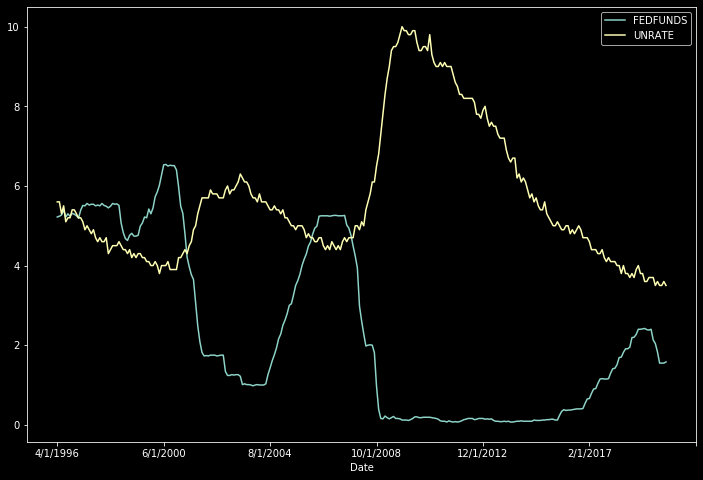

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
econ_df[['FEDFUNDS', 'UNRATE']].plot(ax=ax);

In [17]:
dayton_housing = pd.concat([ohio_df['Dayton'], econ_df], axis=1)
dayton_housing['Dayton'] = dayton_housing['Dayton'].astype('int64')

In [18]:
dayton_housing.head()

,Dayton,CPIAUCSL,FEDFUNDS,INDPRO,UNRATE,DJI_Open,DJI_High,DJI_Low,DJI_Close,DJI_Adj Close,DJI_Volume,GSPC_Open,GSPC_High,GSPC_Low,GSPC_Close,GSPC_Adj Close,GSPC_Volume
1996-04-01,94145,156.1,5.22,76.4562,5.6,5588.600098,5697.689941,5415.529785,5569.080078,5569.080078,756530000.0,645.500000,656.679993,624.140015,654.169983,654.169983,8.875580e+09
1996-05-01,94815,156.4,5.24,77.0161,5.6,5567.600098,5796.100098,5342.200195,5643.180176,5643.180176,801900000.0,654.169983,681.099976,630.070007,669.119995,669.119995,8.921140e+09
1996-06-01,95417,156.7,5.27,77.6669,5.3,5643.899902,5742.540039,5580.379883,5654.629883,5654.629883,647790000.0,669.119995,680.320007,658.750000,670.630005,670.630005,7.930840e+09
1996-07-01,95951,157.0,5.40,77.5662,5.5,5654.600098,5733.310059,5182.319824,5528.910156,5528.910156,781850000.0,670.630005,675.880005,605.880005,639.950012,639.950012,8.849860e+09
1996-08-01,96402,157.2,5.22,78.0160,5.1,5528.899902,5739.020020,5524.100098,5616.209961,5616.209961,615820000.0,639.950012,670.679993,639.489990,651.989990,651.989990,7.380320e+09


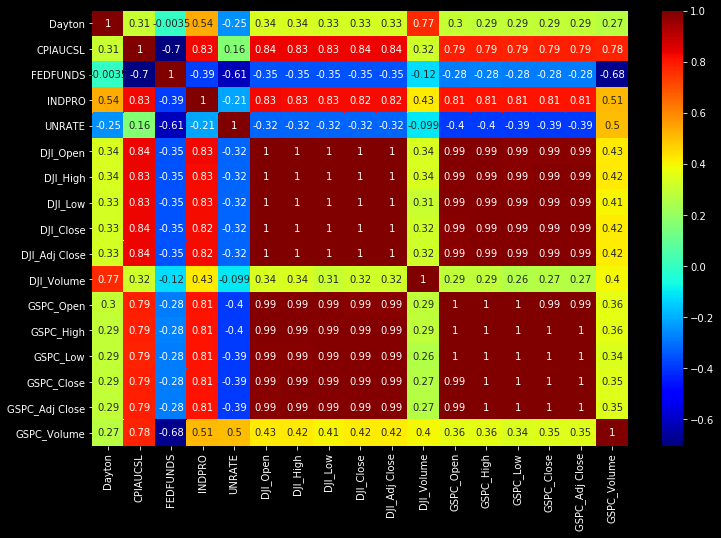

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(dayton_housing.corr(), cmap='jet', annot=True);

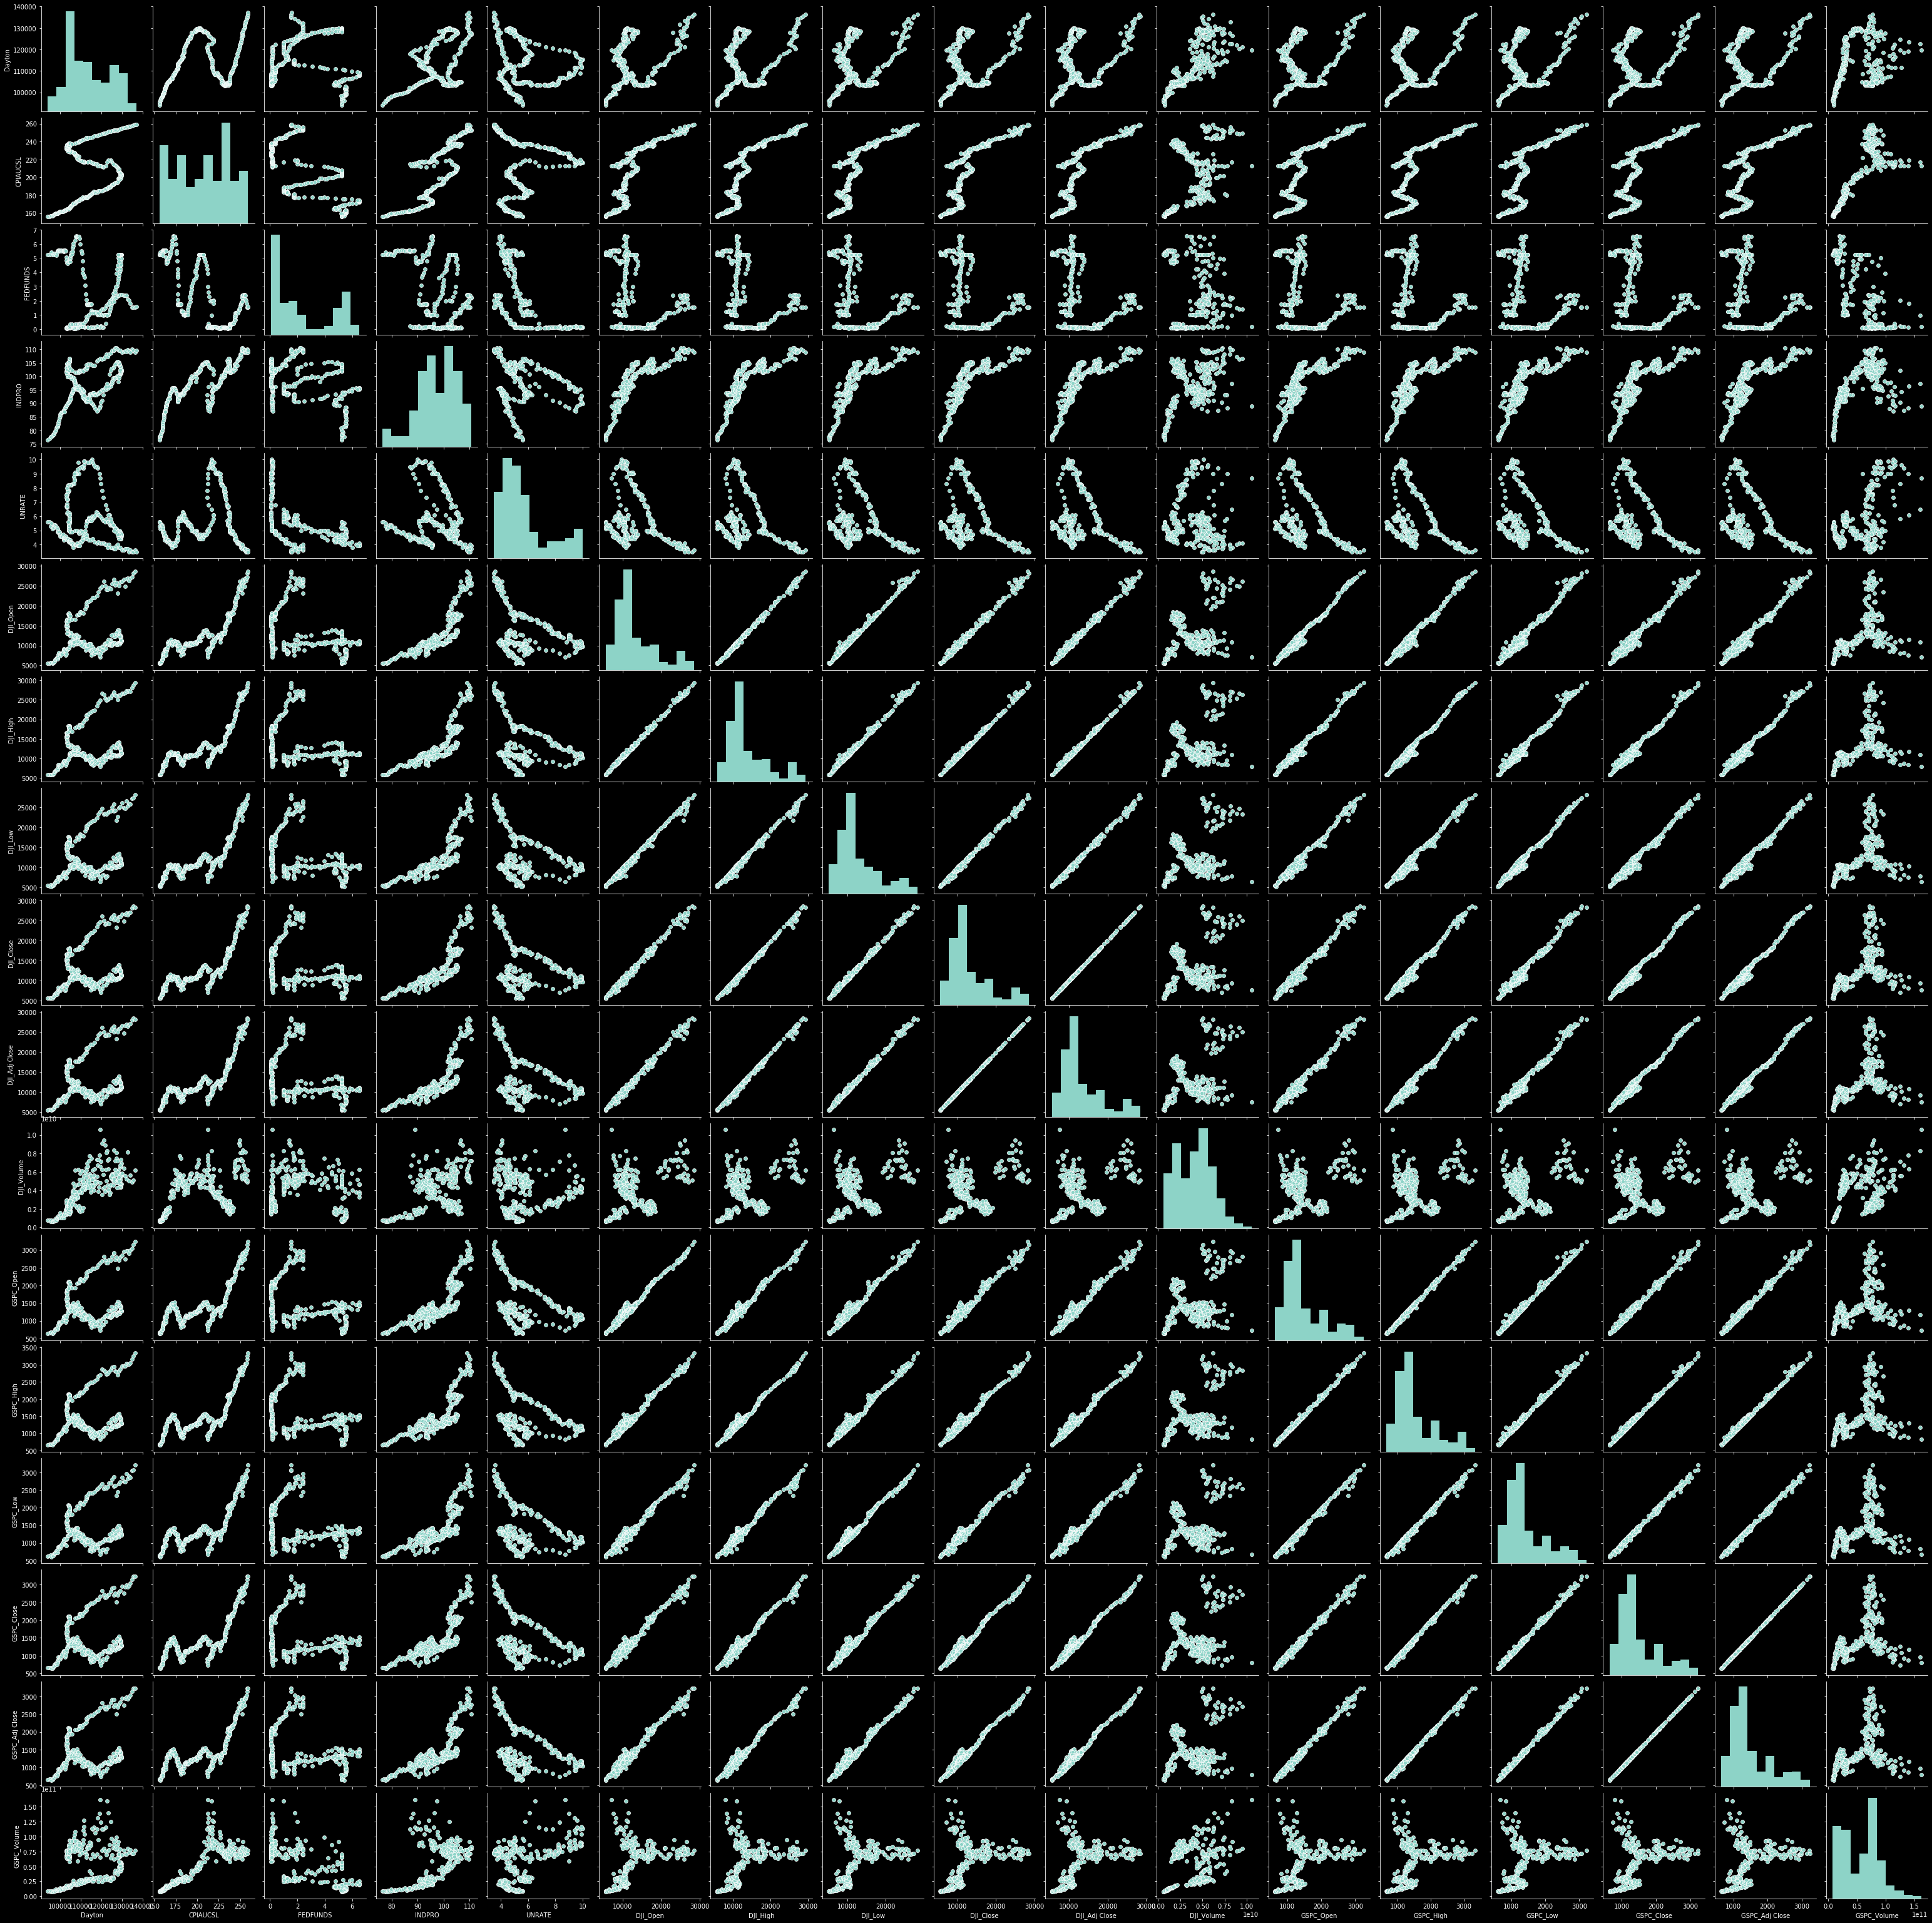

In [20]:
sns.pairplot(dayton_housing);

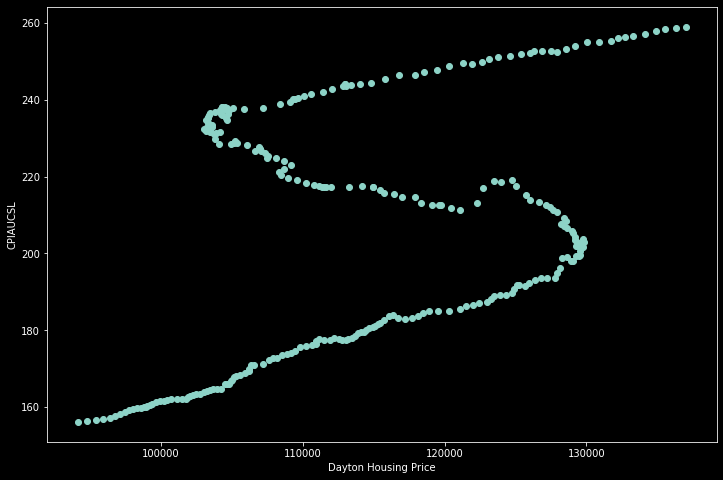

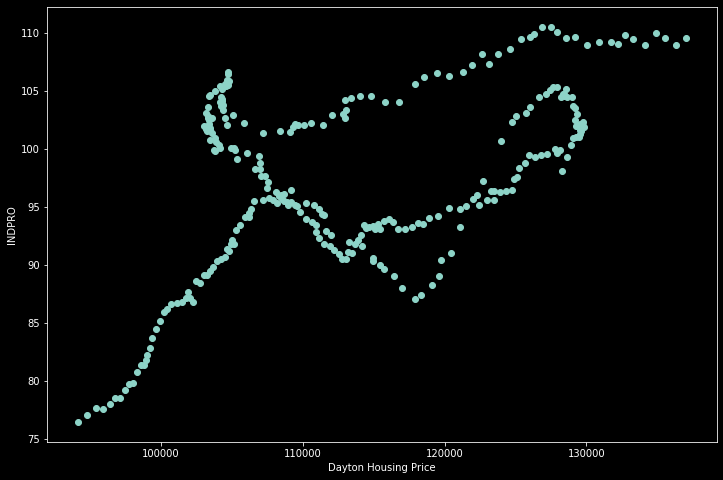

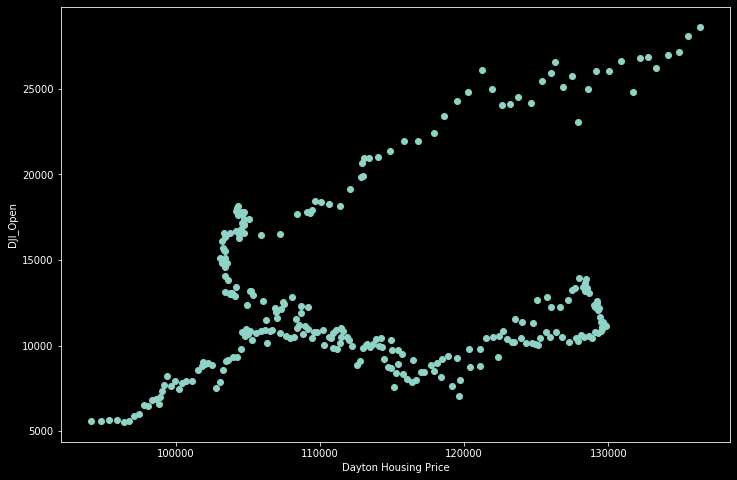

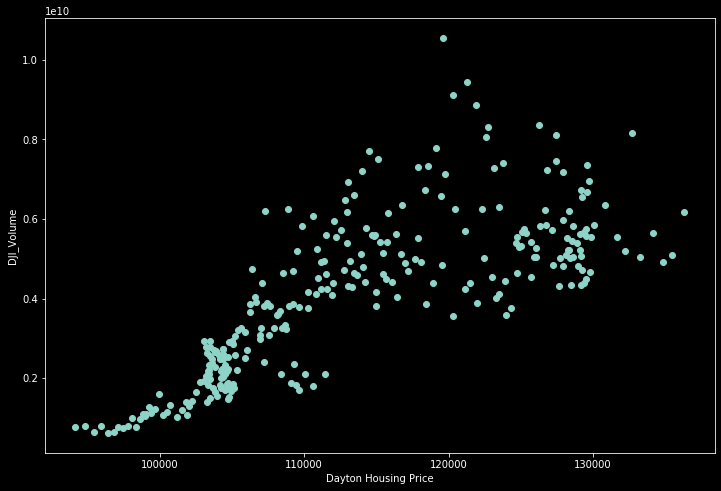

In [21]:
for col in dayton_housing[['CPIAUCSL', 'INDPRO', 'DJI_Open', 'DJI_Volume']]:
    fig, ax = plt.subplots(figsize=(12, 8))
#     plt.plot(dayton_housing[['Dayton', col]])
    plt.scatter(x=dayton_housing['Dayton'], y=dayton_housing[col])
    plt.xlabel('Dayton Housing Price')
    plt.ylabel(f'{col}')
    plt.show()

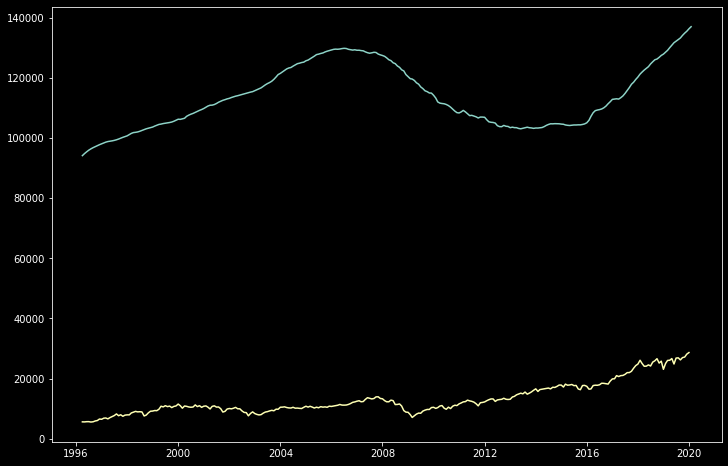

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(dayton_housing[['Dayton', 'DJI_Open']]);

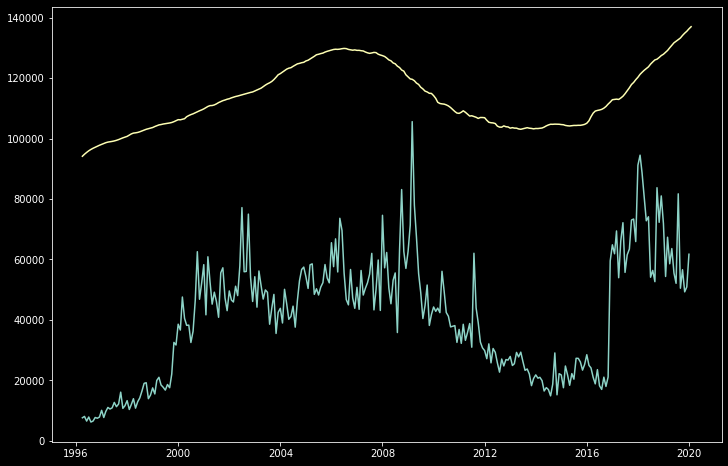

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(dayton_housing['DJI_Volume'] / 100000)
plt.plot(dayton_housing['Dayton']);

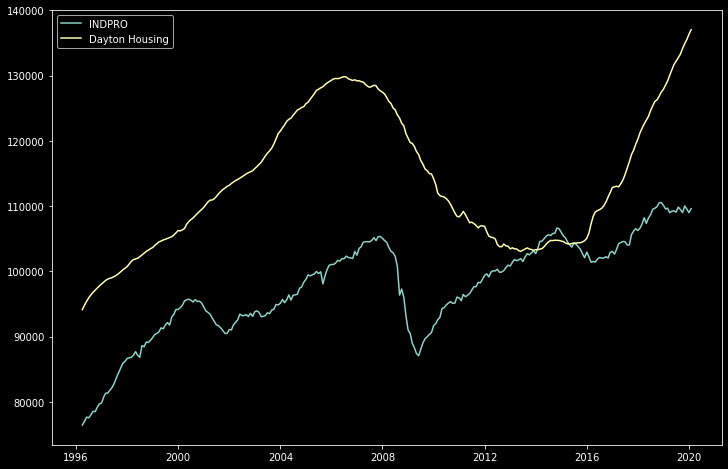

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(dayton_housing['INDPRO'] * 1000, label='INDPRO')
plt.plot(dayton_housing['Dayton'], label='Dayton Housing')
plt.legend();

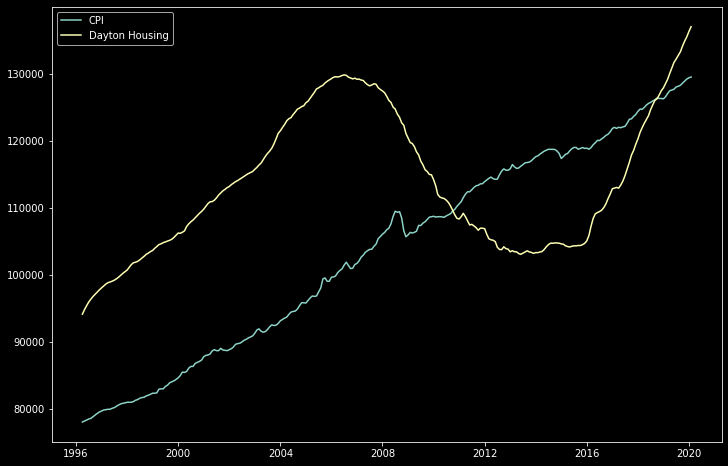

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(dayton_housing['CPIAUCSL'] * 500, label='CPI')
plt.plot(dayton_housing['Dayton'], label='Dayton Housing')
plt.legend();

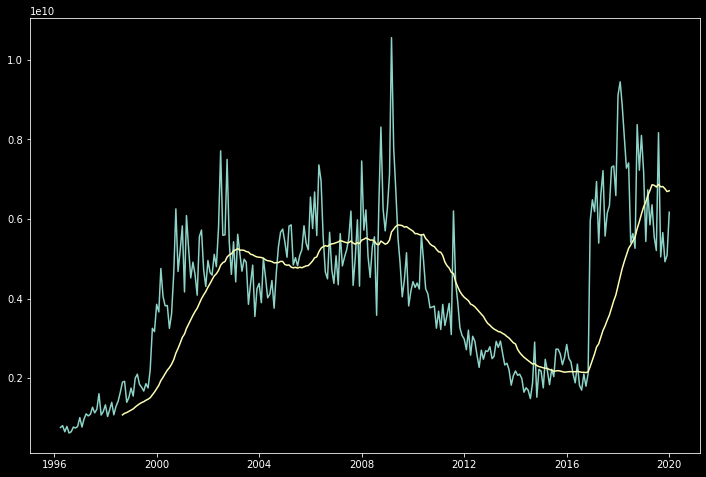

In [26]:
# Lets try to smooth the volume. That seems to be the closest variable in terms of trends
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(dayton_housing['DJI_Volume'])
plt.plot(dayton_housing['DJI_Volume'].rolling(30).mean())

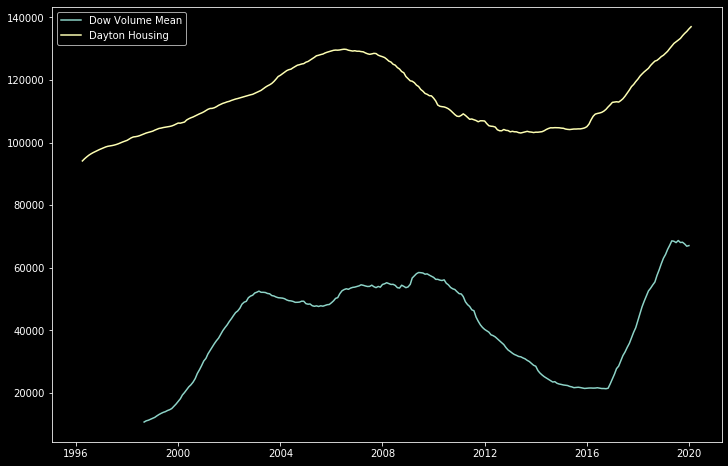

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(dayton_housing['DJI_Volume'].rolling(30).mean() / 100000, label='Dow Volume Mean')
plt.plot(dayton_housing['Dayton'], label='Dayton Housing')
plt.legend();